* <a href="#H2B"> Analysing Michael Olma data set with the H2b fluorescent marker </a>
    * <a href="#Unnormalized"> Unnormalized H2b data set</a>
    * <a href="#Normalized">Normalized</a>
    * <a href="#MitoseOrNot">Classifier: Mitosis or not</a>

In [1]:
### All the packages we need:
%matplotlib inline
%load_ext rpy2.ipython

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl


# <a name="Unnormalized"></a> Unnormalized H2b data set

In [4]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data.csv"):
    print "The file existed so I loaded it."
    H2b = Traj_data(file_name="H2b_data.csv")#,pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b=Traj_data() 

    H2b.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)

    H2b.Add_traj(normalize=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b.data.to_csv('H2b_data.csv',index=False,header=True)    

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/naylor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
print "The training set has %d instances and %d features"%H2b.train.shape
print "The training set has only %d charateristic features out of %d"%(len(H2b.names),H2b.train.shape[1])

_rand_index_train=(random.sample(H2b.train.index,5))
_rand_col  = random.sample(H2b.names,5)
H2b.train.ix[_rand_index_train,_rand_col]

The training set has 1273 instances and 246 features
The training set has only 239 charateristic features out of 246


,h2_IDM,ls1_IRGL_sample_mean,gyration_ratio,granu_open_volume_3,h1_2SHA
24128,1.000000,17.395339,0.024514,0.013737,1372.705575
25215,1.000000,18.739198,0.026603,0.018784,653.300101
19725,0.979984,18.013561,0.022982,0.018751,1463.928610
20829,1.000000,16.797868,0.028735,0.022736,1599.961528
25268,1.000000,20.538259,0.033023,0.003060,1443.005215


In [6]:
info_col=[num_str+"_id_frame",num_str+"_id_object",num_str+"_line_id",num_str+"_pos_x",num_str+"_pos_y","traj","Type"]
H2b.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
24128,232,85,24128,1160,600,18,2
25215,240,60,25215,903,456,40,S
19725,198,71,19725,538,565,4,2
20829,207,41,20829,1029,390,57,1
25268,240,118,25268,488,755,75,1


Processing time: 111.897336 in sec
training dataset: 

S    546
1    378
2    236
M    113
Name: Type, dtype: int64
We now have a classifier with n=330, with an expected accuracy of 0.702 



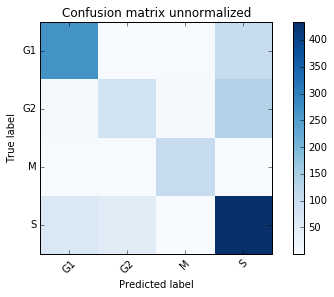

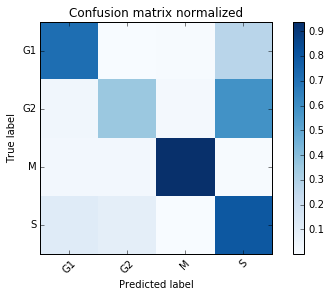

In [7]:
if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model=RandomForest_Autotunner(values)

model.tunning(H2b.train[H2b.names],H2b.train["Type"],3,plot=True,fit_new_model=True)
print "training dataset: \n"
print H2b.train["Type"].value_counts()

i_=np.argmax(model.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f \n" %(n_tree,max(model.MSE))

plot_matrix(model.cm,title="Confusion matrix unnormalized")
plt.show()
model.cm_normalized = model.cm.astype('float') / model.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model.cm_normalized,title="Confusion matrix normalized")
plt.show()

In [8]:
index_no_missing=H2b.data[H2b.names].dropna(axis=0, how='any').index
H2b.data.ix[index_no_missing,"Classif_1"]=model.predict(H2b.data.ix[index_no_missing,H2b.names])
H2b.update()
print "Frequency of predicted values: \n"
print H2b.data["Classif_1"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b.data.shape[0]-len(index_no_missing))

Updated member Group_of_traj
Frequency of predicted values: 

1    33697
S    31099
2     8547
M     5338
Name: Classif_1, dtype: int64

 We were however not able to predict 7 instances because of missing values


In [9]:
temp_X= H2b.data[pd.notnull(H2b.data["traj"])]["Classif_1"]

print "Frequency within trajectories: \n"
print temp_X.value_counts()

print "\n We were however not able to predict %d instances because of missing values" % (sum(pd.isnull(temp_X)))

Frequency within trajectories: 

S    13474
1    12393
2     2575
M     1372
Name: Classif_1, dtype: int64

 We were however not able to predict 0 instances because of missing values


# <a name="Normalized"></a> Normalized data set

In [11]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data_norm_mult.csv"):
    print "The file existed so I loaded it."
    H2b_n_m = Traj_data(file_name="H2b_data_norm_mult.csv")#,pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b_n_m=Traj_data(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2b_n_m.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
    H2b_n_m.add_error()
    H2b_n_m.Add_traj(normalize=True)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b_n_m.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b_n_m.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b_n_m.data.to_csv('H2b_data_norm_mult.csv',index=False,header=True) 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


In [12]:
H2b_n_m.train.ix[_rand_index_train,_rand_col]

,h2_IDM,ls1_IRGL_sample_mean,gyration_ratio,granu_open_volume_3,h1_2SHA
24128,1.739790,0.934439,0.542206,0.118070,0.247955
25215,1.915725,1.127433,0.522302,0.114762,0.134008
19725,1.460882,1.039329,0.522676,0.153792,0.339925
20829,1.839588,0.956780,0.602491,0.145943,0.398805
25268,2.476069,1.161883,0.696345,0.020572,0.246480


In [13]:
H2b_n_m.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
24128,232,85,24128,1160,600,18,2
25215,240,60,25215,903,456,40,S
19725,198,71,19725,538,565,4,2
20829,207,41,20829,1029,390,57,1
25268,240,118,25268,488,755,75,1


If we look at the features of a certain trajectory

In [14]:
traj=0
H2b_n_m.data.ix[H2b_n_m.data["traj"]==traj,_rand_col+[num_str+"_id_frame"]]

,h2_IDM,ls1_IRGL_sample_mean,gyration_ratio,granu_open_volume_3,h1_2SHA,0015_id_frame
400,1.000000,1.000000,1.000000,1.000000,1.000000,5
473,1.561849,1.045152,0.829797,0.324903,0.427949,6
546,1.627714,0.989899,0.851252,0.278689,0.267740,7
620,1.710227,1.149111,0.798334,0.449330,0.366396,8
694,1.894835,1.020020,0.722577,0.213566,0.227243,9
771,1.933018,0.994233,0.749965,0.178984,0.168960,10
844,1.928425,0.958907,0.693587,0.153398,0.222846,11
920,1.945746,0.954170,0.666039,0.160185,0.273724,12
993,1.940480,0.817564,0.686136,0.088329,0.093643,13
1071,1.945746,0.907281,0.663225,0.065606,0.174928,14


We now have to be careful, not all the training points are part of a trajectory. So we can't compare (with all fairness) the results exposed above with the normalised version.

Updated member Group_of_traj
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 53.919479 in sec


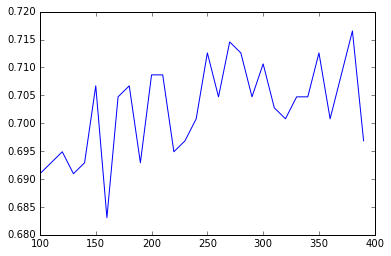

We now have a classifier with n=380, with an expected accuracy of 0.717 for the unnormalized data. 



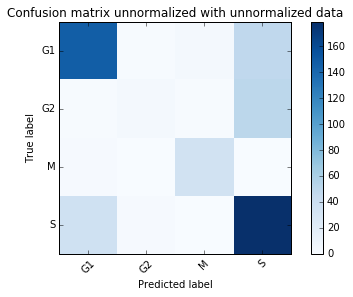

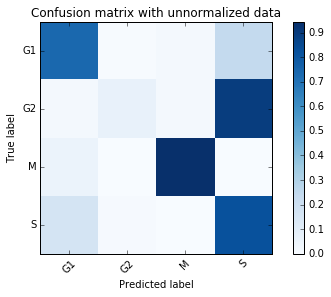

Processing time: 54.421947 in sec


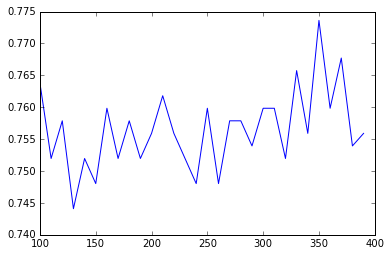

We now have a classifier with n=350, with an expected accuracy of 0.774 for the normalized data. 



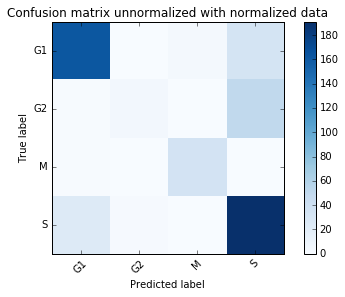

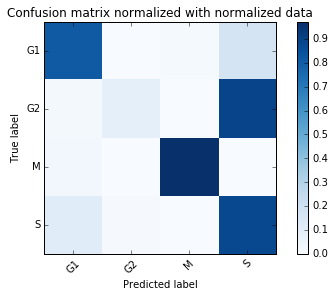

In [15]:

kfold=3

instances_to_keep=pd.notnull(H2b_n_m.data.traj)

H2b.data=H2b.data.ix[instances_to_keep,H2b.data.columns]
H2b.update()

H2b_n_m.data=H2b_n_m.data.ix[instances_to_keep,H2b_n_m.data.columns]
H2b_n_m.update()

print "training dataset: \n"
print H2b_n_m.train["Type"].value_counts()

if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_t=RandomForest_Autotunner(values)

model_t.tunning(H2b.train[H2b.names],H2b.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_t.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the unnormalized data. \n" %(n_tree,max(model_t.MSE))

plot_matrix(model_t.cm,title="Confusion matrix unnormalized with unnormalized data")
plt.show()
model_t.cm_normalized = model_t.cm.astype('float') / model_t.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_t.cm_normalized,title="Confusion matrix with unnormalized data")
plt.show()



if H2b_n_m.Var_missing[0] in H2b_n_m.train.columns:
    H2b_n_m.missing_features_train()
if H2b_n_m.Var_missing[0] in H2b_n_m.data.columns:
    H2b_n_m.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train[H2b_n_m.names],H2b_n_m.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data")
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data")
plt.show()

# <a name="MitoseOrNot"></a> Classifier for Mitosis or Not

In [17]:
train_file="MitoseClassif.arff"

train_1=Reader()
train_1.arrf_read(train_file)
train_1.renaming_for_mitosis()

train_1.data["label"].value_counts()

Reader constructed


O    2842
S    1293
M    1016
Name: label, dtype: int64

Processing time: 538.682555 in sec


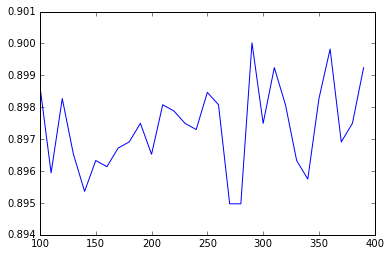

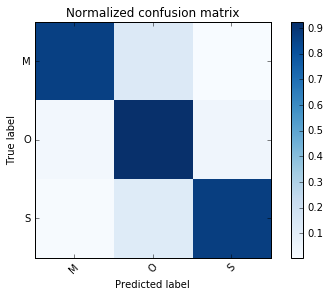

In [18]:
kfold=3

if train_1.Var_missing[0] in train_1.data.columns:
    train_1.missing_features_data()
    
values=[100 + i*10 for i in range(30)]
model_1=RandomForest_Autotunner(values)

model_1.tunning(train_1.data[train_1.names],train_1.data["label"],kfold,plot=True,fit_new_model=True)
plt.show()

model_1.cm_normalized = model_1.cm.astype('float') / model_1.cm.sum(axis=1)[:, np.newaxis]

plot_matrix(model_1.cm_normalized,title="Normalized confusion matrix",names=["M","O","S"])
plt.show()

# <a name="Fusion"></a> Predicting and regrouping the first predictor and the 3 state predictor

Because we have too few instances in phase M, we used the first classifier. This classifier has priority over the first prediction as it the H2B marker is meant to be informative about the Mitosis events.

Updated member Group_of_traj
Updated member Group_of_traj
Frequency of predicted values for the Mitosis or not classifier: 

O    14762
S    14204
M      848
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
Name: Type, dtype: int64
Processing time: 51.060756 in sec


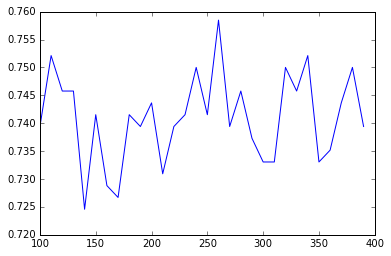

We now have a classifier with n=260, with an expected accuracy of 0.758 for the normalized data. 



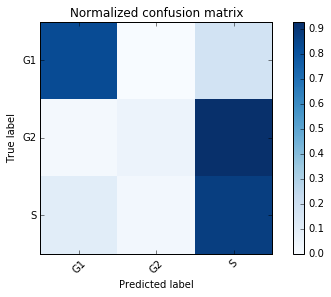

Frequency of predicted values for the 3 state classifier: 

1    15998
S    12509
2     1307
Name: 3State, dtype: int64


In [19]:
## To reduce computation and none useless things, we remove instances that do not belong to trajectories.

index_traj=pd.notnull(H2b_n_m.data["traj"])
H2b_n_m.data=H2b_n_m.data.ix[index_traj,H2b_n_m.data.columns]
H2b.data=H2b.data.ix[index_traj,H2b.data.columns]

H2b_n_m.update()
H2b.update()
## Predicting model 1

index_no_missing=H2b_n_m.data[H2b_n_m.names].dropna(axis=0, how='any').index
H2b_n_m.data.ix[index_no_missing,"MitoseOrNot"]=model_1.predict(H2b.data.ix[index_no_missing,train_1.names]) 
## Carefull, we put the unnormalized data in the above prediction.

print "Frequency of predicted values for the Mitosis or not classifier: \n"
print H2b_n_m.data["MitoseOrNot"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b_n_m.data.shape[0]-len(index_no_missing))

H2b_n_m.data

H2b_n_m.update()

##We have to retrain the model for the normalized version as this one was trained with the class M

index_no_M=H2b_n_m.data["Type"]!="M"

print "training dataset: \n"
print H2b_n_m.train.ix[index_no_M,"Type"].value_counts()


values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train.ix[index_no_M,H2b_n_m.names],H2b_n_m.train.ix[index_no_M,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))

model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Normalized confusion matrix",names=["G1","G2","S"])
plt.show()

H2b_n_m.data.ix[index_no_missing,"3State"]=model_n_m.predict(H2b_n_m.data.ix[index_no_missing,H2b_n_m.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"3State"].value_counts()




In [20]:
### Giving priority to the first classif...
def f(value_1,value_2):
    if value_1=="M":
        return(value_1)
    else:
        return(value_2)
H2b_n_m.data["Pred_Fusion"]=H2b_n_m.data.apply(lambda r: f(r["MitoseOrNot"],r["3State"]),axis=1)

print "Frequency of predicted values for the 4 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"Pred_Fusion"].value_counts()
H2b_n_m.update()

Frequency of predicted values for the 4 state classifier: 

1    15153
S    12506
2     1307
M      848
Name: Pred_Fusion, dtype: int64
Updated member Group_of_traj


# Hidden Markov Model

In [21]:
##First we are going to seperate beginning M's and ending M's
for i in range(len(H2b_n_m.trajectories)):
    new_obs=np.array(H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"])
    n_obs=len(new_obs)
    for j in range(n_obs/2):
        if new_obs[j]=='M':
            new_obs[j]='B'  #Beginning
    H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"]=new_obs
H2b_n_m.data.ix[H2b_n_m.data["Pred_Fusion"]=='M',"Pred_Fusion"]='E' #Ending


* What should we put as a emission state probability matrix?

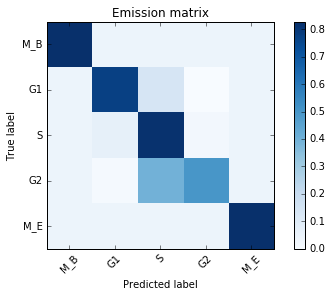

In [44]:
X3=model_n_m.cm_normalized
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T

EmissionMat=np.zeros(shape=(5,5))
EmissionMat[0,0]=model_1.cm_normalized[0,0]
EmissionMat[4,4]=model_1.cm_normalized[0,0]
EmissionMat[1:5,0]=(1-model_1.cm_normalized[0,0])/3
EmissionMat[0:4,4]=(1-model_1.cm_normalized[0,0])/3

### Bricolage

EmissionMat[1:4,1:4]=X3
EmissionMat[1:4,1:3]+=-EmissionMat[3,0]*2/3

### On modifie car la diag n'est pas assez bonne...
EmissionMat[3,2:4]=[0.4,0.5]

EmissionMat[0,1:4]=sum(model_1.cm_normalized[0,1:3])/3
EmissionMat[4,1:4]=sum(model_1.cm_normalized[0,1:3])/3

EmissionMat=abs(EmissionMat).astype('float') / abs(EmissionMat).sum(axis=1)[:, np.newaxis]
## Put something better then abs... 

plot_matrix(EmissionMat,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()

H2b_n_m.data=H2b_n_m.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])

data=H2b_n_m.data.ix[pd.notnull(H2b_n_m.data["traj"]),["traj","Pred_Fusion"]]


data.ix[data.Pred_Fusion=='2',"Pred_Fusion"]="4"
data.ix[data.Pred_Fusion=='1',"Pred_Fusion"]="2"
data.ix[data.Pred_Fusion=='B',"Pred_Fusion"]="1"
data.ix[data.Pred_Fusion=='E',"Pred_Fusion"]="5"
data.ix[data.Pred_Fusion=='S',"Pred_Fusion"]="3"

%Rpush EmissionMat
%Rpush data 

In [46]:
%%R 
obs_number=0
print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

library(HMM)
trans=list()  #List of outputs
emi=list()    

emission_matrix=EmissionMat
transition_prior=t(matrix(c(  .7  , .27 , .01 , .01 , .01
                            , .01 , .7  , .27 , .01 , .01
                            , .01 , .01 , .7  , .27 , .01
                            , .01 , .01 , .01 , .7  , .27
                            , .01 , .01 , .01 , .01  , 0.96 ),5)) 

startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transition_prior,
              emissionProbs=emission_matrix
              ,startProbs=startProbs)


n_traj=max(data$traj)
j=1
for (i in 0:(n_traj-1)){
    obs=data[data$traj==i,"Pred_Fusion"]
    if (i==obs_number){
        test=obs
        print(test)
    }
    
    hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
                  startProbs=startProbs,
                  emissionProbs=emission_matrix,
                  transProbs=transition_prior)
    bw=try(baumWelch(hmm,observation=obs,10),silent = TRUE)
    if (!(inherits(bw, "try-error"))){
      trans[[j]]=bw$hmm$transProbs
      emi[[j]]=bw$hmm$emissionProbs
      j=j+1  
    }
}

mean_t=matrix(0,ncol=5,nrow=5)
mean_e=matrix(0,ncol=5,nrow=5)
for (i in 1:length(trans)){
  mean_t=mean_t+trans[[i]]
  mean_e=mean_e+emi[[i]]
}
mean_t=mean_t/length(trans)
mean_e=mean_e/length(trans)

var_t=matrix(0,ncol=5,nrow=5)
var_e=matrix(0,ncol=5,nrow=5)

for (i in 1:length(trans)){
  var_t=var_t+(trans[[i]]-mean_t)*(trans[[i]]-mean_t)
  var_e=var_e+(emi[[i]]-mean_e)*(emi[[i]]-mean_e)
}
var_t=var_t/length(trans)
var_e=var_e/length(trans)

[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 3 2 3 2 3 3 3 2 2
 [75] 2 3 3 3 3 3 3 2 3 3 2 3 2 2 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4
[149] 3 3 3 3 3 3 3 3 4 3 3 4 4 3 3 3 3 3 4 3 3 4 4 3 3 3 4 4 4 4 4 3 5 5 5 5 2
Levels: 1 2 3 4 5


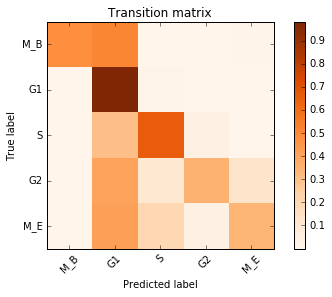

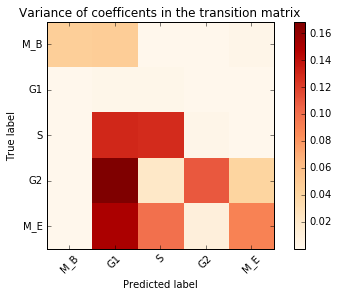

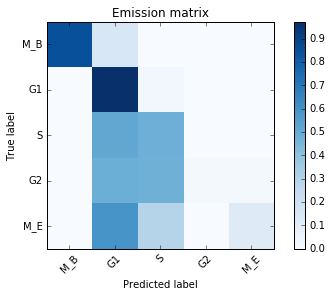

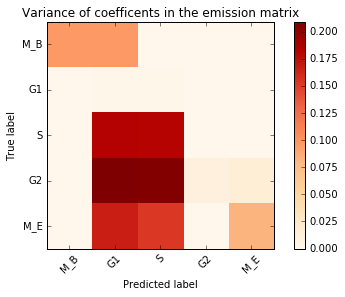

In [47]:
%Rpull mean_t mean_e var_t var_e
plot_matrix(mean_t,title="Transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()

In [48]:
%%R 
obs_number=2

ligne1=mean_t[1,1]+mean_t[1,2]
ligne2=mean_t[2,2]+mean_t[2,3]
ligne3=mean_t[3,3]+mean_t[3,4]
ligne4=mean_t[4,4]+mean_t[4,5]

transProbs=t(matrix(c(mean_t[1,1]/ligne1  , mean_t[1,2]/ligne1    ,0                 , 0                 ,0
                      , 0                 , mean_t[2,2]/ligne2    ,mean_t[2,3]/ligne2, 0                 ,0
                      , 0                 , 0                     ,mean_t[3,3]/ligne3, mean_t[3,4]/ligne3,0
                      , 0                 , 0                     ,0                 , mean_t[4,4]/ligne4,mean_t[4,5]/ligne4
                      , 0                 , 0                     ,0                 , 0                 ,1 ),5))
startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transProbs,
              emissionProbs=emission_matrix  ##We still keep the confusion matrix of the first classification
              ,startProbs=startProbs)

print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

for (i in 0:(n_traj-1)){
  obs=data[data$traj==i,"Pred_Fusion"]
  new_obs=as.integer(viterbi(hmm,observation=obs))
  data[data$traj==i,"HMM"]=new_obs
  if (i==obs_number){
      print(obs)
      print(new_obs)
  }
}


[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 2"
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 2
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 4 4 3 3 3 4
[186] 4 4 4 5 5 2 2
Levels: 1 2 3 4 5
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4
[186] 4 4 4 5 5 5 5


In [54]:
## If needed...
H2b_n_m.data=H2b_n_m.data.drop("HMM",axis=1)

In [55]:
%Rpull data

data.ix[data.HMM==1,"HMM"]="M"
data.ix[data.HMM==2,"HMM"]="1"
data.ix[data.HMM==3,"HMM"]="S"
data.ix[data.HMM==4,"HMM"]="2"
data.ix[data.HMM==5,"HMM"]="M"
to_join=pd.Series(data["HMM"])
to_join.index=[int(el) for el in to_join.index]

H2b_n_m.data=H2b_n_m.data.join(to_join)
H2b_n_m.update()


print H2b_n_m.train.ix[_rand_index_train,["traj","Type","MitoseOrNot","3State","Pred_Fusion","HMM"]]


obs_number=2
i=0
G1=[]
S=[]
G2=[]
CC=[]
print "To quickly asses we print the trajectory and his corrected trajectory, for sequence number:" + str(obs_number)
for el in H2b_n_m.Group_of_traj:
    new_obs=el[1]["HMM"]
    if i==obs_number:
        test=np.array(el[1]["Pred_Fusion"])
        test_hmm=np.array(el[1]["HMM"])
        print "Pred_Fusion: \n"
        print test
        print "\n Corrected HMM: \n"
        print test_hmm
    i+=1
    if not check_rotate(new_obs):
        G1.append(Measure(new_obs,'1',_last=True))
        S.append(Measure(new_obs,'S',_last=True,_first=True))
        G2.append(Measure(new_obs,'2',_first=True))
        CC.append(Measure(new_obs,'M'))
    elif not check_rotate(new_obs[:-1]):
        G1.append(Measure(new_obs[:-1],'1',_last=True))
        S.append(Measure(new_obs[:-1],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-1],'2',_first=True))
        CC.append(Measure(new_obs[:-1],'M'))
    elif not check_rotate(new_obs[:-2]):
        G1.append(Measure(new_obs[:-2],'1',_last=True))
        S.append(Measure(new_obs[:-2],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-2],'2',_first=True))
        CC.append(Measure(new_obs[:-2],'M'))
    else:
        G1.append(-1)
        S.append(-1)
        G2.append(-1)
        CC.append(-1)
        
from numpy import mean,std
ratio=5.9/60
G1_p=[el*ratio for el in G1 if el>-1]
S_p= [el*ratio for el in S  if el>-1]
G2_p=[el*ratio for el in G2 if el>-1]
CC_p=[el*ratio for el in CC if el>-1] 
res = {'mean' : pd.Series([mean(G1_p), mean(S_p), mean(G2_p),mean(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Standard deviation' : pd.Series([std(G1_p),std(S_p),std(G2_p),std(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Accepted trajectories': pd.Series([len(G1_p),len(S_p),len(G2_p),len(CC_p)], index=['G1', 'S', 'G2','CellCycle'])
      }

Updated member Group_of_traj
       traj Type MitoseOrNot 3State Pred_Fusion HMM
24128    18    2           S      2           2   2
25215    40    S           S      S           S   S
19725     4    2           S      2           2   2
20829    57    1           S      1           1   1
25268    75    1           O      1           1   1
To quickly asses we print the trajectory and his corrected trajectory, for sequence number:2
Pred_Fusion: 

['B' 'B' 'B' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' 'S' 'S'
 '1' '1' '1' '1' '1' '1' '1' '1' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'

# Results of classification

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
We reach an accuracy of 0.886 



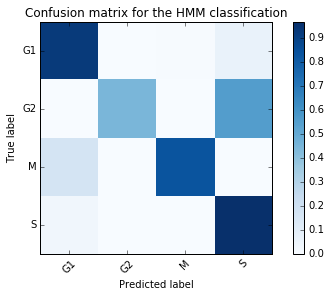

In [58]:
from sklearn.metrics import confusion_matrix

temp_X=H2b_n_m.train.ix[pd.notnull(H2b_n_m.train["HMM"]),["HMM","Type"]]
print temp_X["Type"].value_counts()
cm=confusion_matrix(temp_X.Type,temp_X.HMM)

print "We reach an accuracy of %5.3f \n" %(float(cm.trace())/cm.sum())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_matrix(cm_normalized,title="Confusion matrix for the HMM classification")

Most of the errors are made between S and G2, if we regroup them we achieve these results.

T    273
1    199
M     36
Name: Type, dtype: int64
We reach an accuracy of 0.947 



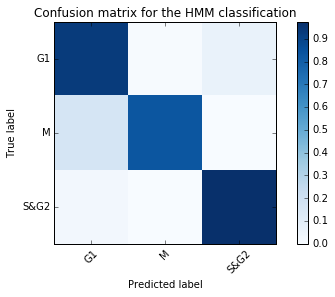

In [67]:
temp_X=H2b_n_m.train.ix[pd.notnull(H2b_n_m.train["HMM"]),["HMM","Type"]]

temp_X.ix[temp_X.Type=="S","Type"]="T" #Together
temp_X.ix[temp_X.HMM=="S","HMM"]="T"
temp_X.ix[temp_X.Type=="2","Type"]="T"
temp_X.ix[temp_X.HMM=="2","HMM"]="T"


print temp_X["Type"].value_counts()


cm=confusion_matrix(temp_X.Type,temp_X.HMM)

print "We reach an accuracy of %5.3f \n" %(float(cm.trace())/cm.sum())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_matrix(cm_normalized,title="Confusion matrix for the HMM classification",names=["G1","M","S&G2"])

Our classifier seems to seperate correctly phases G1 and S.

# Time analysis of cell cycle phases


In [57]:
print "With only M: \n"
pd.DataFrame(res)

With only M: 



,Accepted trajectories,Standard deviation,mean
G1,163,3.915669,7.130072
S,101,3.158472,8.131485
G2,101,2.173191,1.712558
CellCycle,101,2.271532,17.224884


The time for G1 is the same as the time extracted from the PCNA fluorescent marker. This confirms that we feel that we can seperate G1 and S.